In [6]:
import cv2

import tensorflow as tf
import keras
import numpy as np

tf.__version__, keras.__version__

('2.15.0', '3.0.0')

In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
from utils.layers import PatchEmbedding, PatchMerging, SwinTransformer, WindowAttention

In [9]:
model = tf.keras.models.load_model('../models/swin.keras', custom_objects={
    'PatchEmbedding':PatchEmbedding, 
    'PatchMerging':PatchMerging,
    'SwinTransformer':SwinTransformer,
    'WindowAttention':WindowAttention,        
})
model.summary()

/home/main/.local/lib/python3.11/site-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'patch_embedding_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/main/.local/lib/python3.11/site-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'patch_merging_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 4)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_embedding_2               │ (None, 256, 64)           │     16,704 │
│ (PatchEmbedding)                │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer_4              │ (None, 256, 64)           │     50,072 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer_5              │ (None, 256, 64)           │     51,096 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_merging_2 (PatchMerging)  │ (None, 64, 128)           │     32,768 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d_2      │ (None, 128)               │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_38 (Dense)                │ (None, 1024)              │    132,096 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_39 (Dense)                │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_40 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_41 (Dense)                │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,839,925 (10.84 MB)

 Trainable params: 946,289 (3.61 MB)

 Non-trainable params: 1,056 (8.25 KB)

 Optimizer params: 1,892,580 (7.22 MB)

(32, 32)


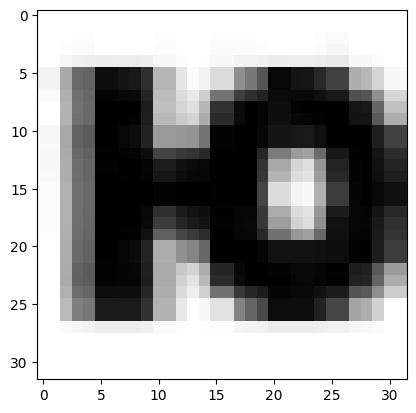

In [10]:
import cv2
import matplotlib.pyplot as plt

input_shape = (32,32,1)

let = cv2.imread('../data/letterlist.jpg', 0)
let = let[15:780,:]
num_letters = 33
num_fonts = 21


def crop_image(img, trashold=250):
    top = 0
    bottom =0
    left = 0
    right = 0
    for i in range(img.shape[0]):
        if img[i,:].mean() > trashold:
            top = i
        else:
            break
    for i in range(img.shape[0]):
        if img[-i,:].mean() > trashold:
            bottom = i
        else:
            break
    for i in range(img.shape[1]):
        if img[:,i].mean() > trashold:
            left = i
        else:
            break
    for i in range(img.shape[1]):
        if img[:,-i].mean() > trashold:
            right = i
        else:
            break
    left = max(1,left)
    right = max(1,right)
    top = max(1,top)
    bottom = max(1,bottom)
    img = img[top:-bottom, left:-right]

    return img

def get_letter(font_num, letter_num):
    img = let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]
    img_croped = crop_image(img)    
    h,w = img_croped.shape    
    size_max = max(w, h)
    letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
    
    if w > h:
        # Enlarge image top-bottom
        # ------
        # ======
        # ------
        y_pos = size_max // 2 - h // 2
        letter_square[y_pos:y_pos + h, 0:w] = img_croped[:h, :w]
    elif w < h:
        # Enlarge image left-right
        # --||--
        x_pos = size_max // 2 - w // 2
        letter_square[0:h, x_pos:x_pos + w] = img_croped[:h, :w]
    else:
        letter_square = img_croped    

    return cv2.resize(letter_square, input_shape[:-1], interpolation=cv2.INTER_AREA)

def get_letter_variants(letter_num):
        return let[:,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]

def get_font_variants(font_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           :,
           ]
test = get_letter(21,33)
print(test.shape)
plt.imshow(test, cmap='gray')

In [11]:
from utils.augmenters import *

images = []
captions = []
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
for i in range(1, num_fonts+1):
    for j in range(1, num_letters+1):
        images.append(get_letter(i,j))
        captions.append(captions_base[j-1])

aug = MultipleAugmenter(images.copy(), captions.copy())
aug.random_augment(3, 65, 0)


x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
classes = list(map(captions_base.index, aug.captions))
y_data = keras.utils.to_categorical(classes, num_classes=num_letters)


693
1099
1727


In [ ]:
from utils.funcs import patch_extract

def augment(x):
    return x

batch_size = 32

dataset = (
    tf.data.Dataset.from_tensor_slices((x_data, y_data))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
model.load_weights('../models/swin.weights.h5')

In [ ]:
model.evaluate(dataset)

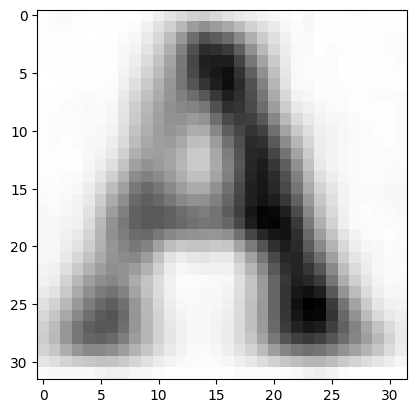

In [32]:
data = []
for i in range(1,74):
    letter = cv2.imread(f'../test/letter{i}.jpg', 0)
    data.append(cv2.resize(letter, input_shape[:-1]))
plt.imshow(data[0], cmap='gray')

In [33]:
data = np.array(data)/255
data = data[:,:,:, np.newaxis]
data.shape

(73, 32, 32, 1)

In [34]:
from utils.funcs import patch_extract

dataset = (
    tf.data.Dataset.from_tensor_slices(data)
    .batch(batch_size=32)
    .map(lambda x: (patch_extract(x)))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [35]:
pred = model.predict(dataset)
pred.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


(73, 33)

In [36]:
pred.argmax(-1)

array([25,  9, 23,  0, 10, 20, 23,  4,  0, 16,  8, 12,  7, 17, 19, 21,  0,
        7, 17,  0, 25, 10, 26,  4, 19,  8, 17, 25, 19, 25, 23, 26, 26, 31,
       20,  0,  7,  9, 30, 21, 19, 31, 31, 27, 24, 32, 29, 16,  0, 18, 31,
        4, 25,  7,  0, 19,  6,  6, 18, 26, 11, 18, 27,  6, 19, 32, 31, 19,
       17, 14,  7,  0,  0])

In [37]:
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
captions = [captions_base[x] for x in pred.argmax(axis=1)]
captions

['Ч',
 'Щ',
 'Э',
 'Ё',
 'З',
 'Л',
 'Э',
 'К',
 'Ё',
 'А',
 'Ш',
 'Ъ',
 'Г',
 'П',
 'О',
 'Д',
 'Ё',
 'Г',
 'П',
 'Ё',
 'Ч',
 'З',
 'С',
 'К',
 'О',
 'Ш',
 'П',
 'Ч',
 'О',
 'Ч',
 'Э',
 'С',
 'С',
 'Б',
 'Л',
 'Ё',
 'Г',
 'Щ',
 'Ь',
 'Д',
 'О',
 'Б',
 'Б',
 'М',
 'Я',
 'Ю',
 'Т',
 'А',
 'Ё',
 'Р',
 'Б',
 'К',
 'Ч',
 'Г',
 'Ё',
 'О',
 'Н',
 'Н',
 'Р',
 'С',
 'Х',
 'Р',
 'М',
 'Н',
 'О',
 'Ю',
 'Б',
 'О',
 'П',
 'Ы',
 'Г',
 'Ё',
 'Ё']

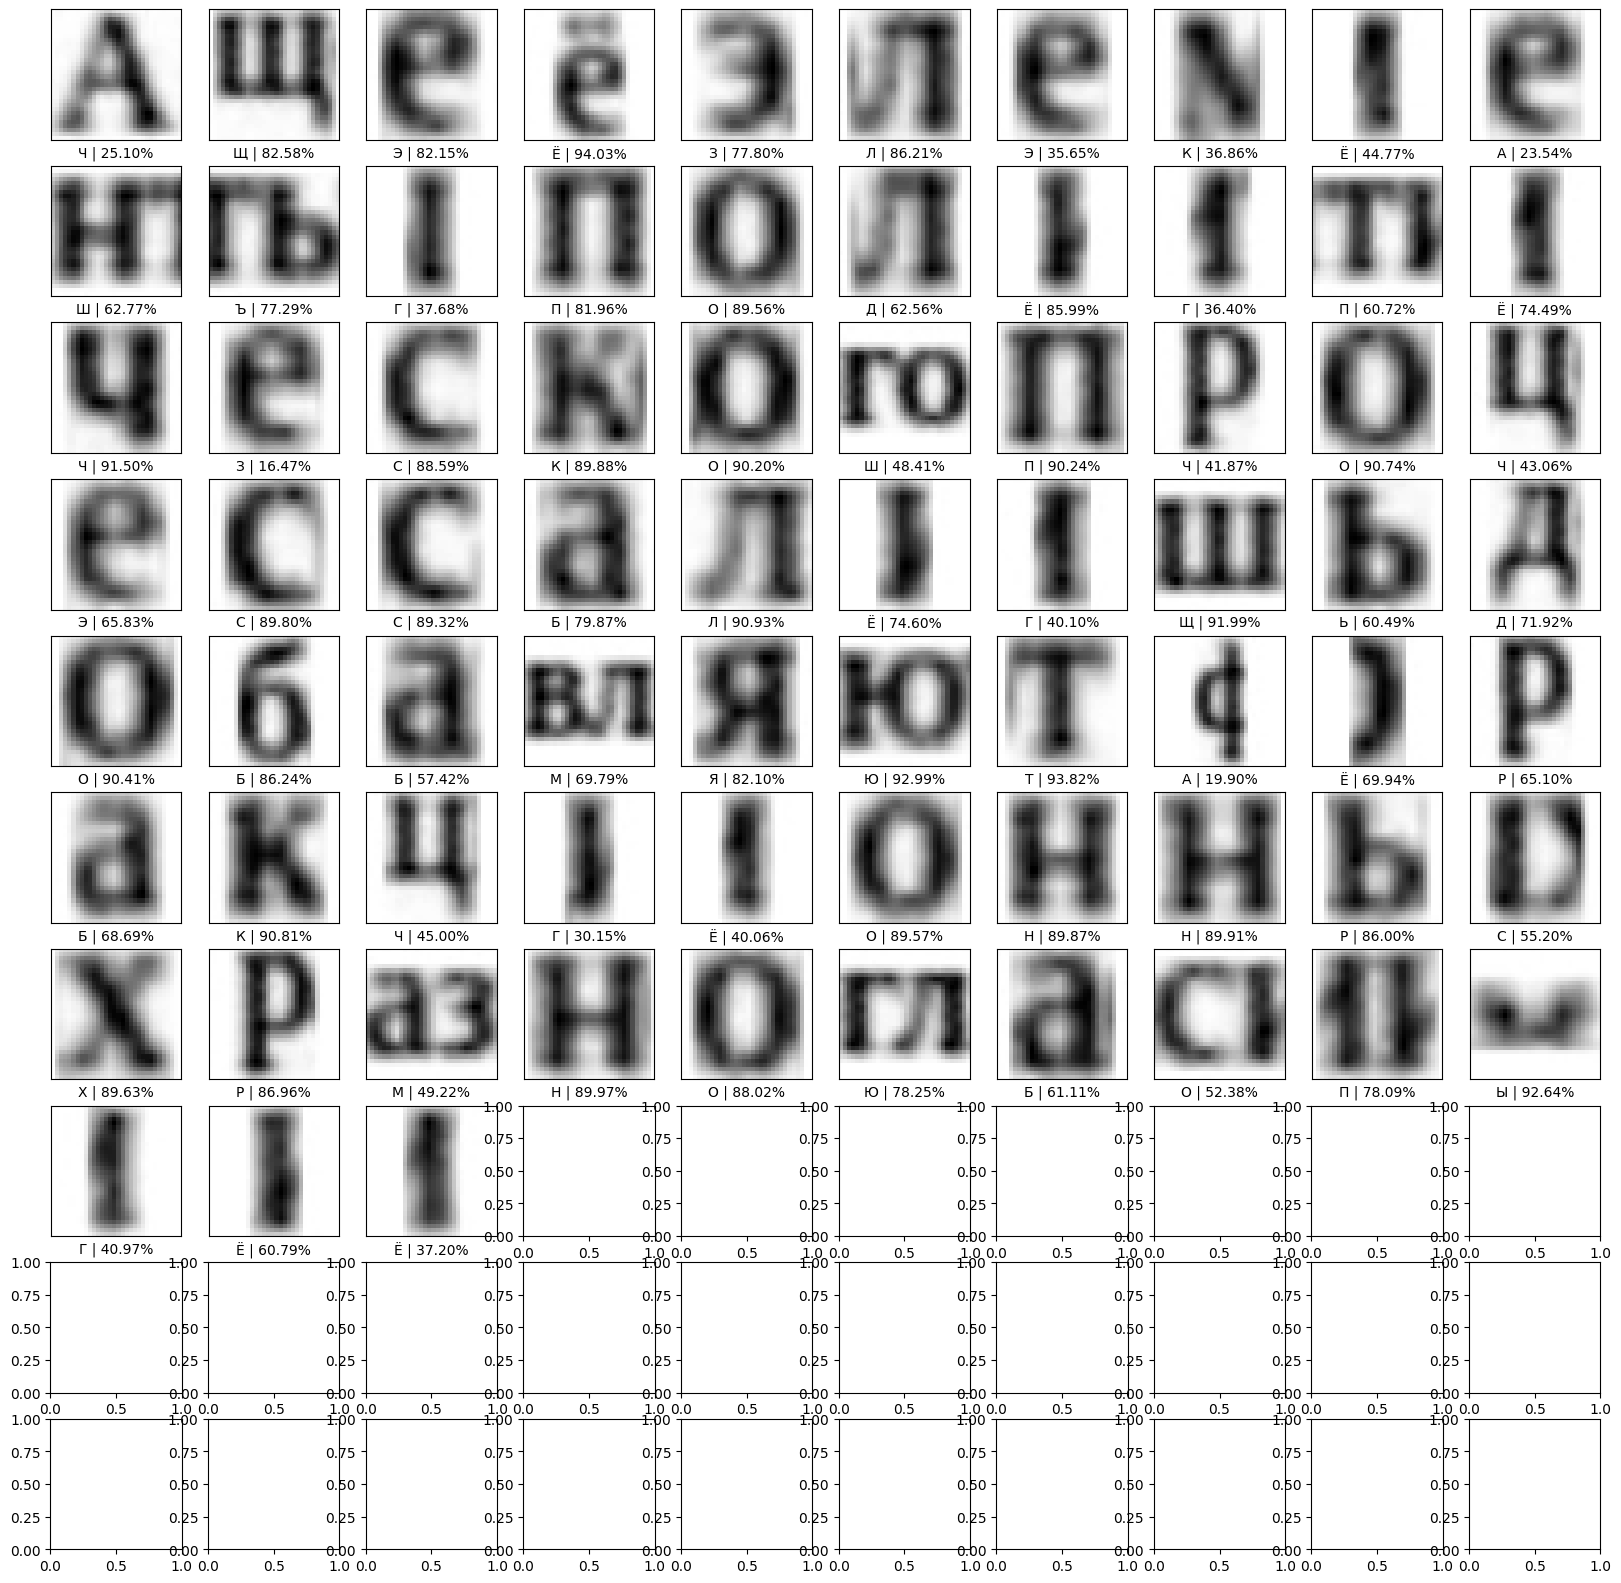

In [38]:
fig, ax = plt.subplots(ncols=10, nrows=10, figsize=(20,20))
letters = data

for i in range(min(100,len(letters))):
    
    ax[i//10, i%10].set_xticks([])
    ax[i//10, i%10].set_yticks([])
    
    ax[i//10, i%10].imshow(letters[i], cmap='gray')
    
    ax[i//10, i%10].set_xlabel(f"{captions[i]} | {pred[i, pred.argmax(-1)[i]]*100:.2f}%")

